In [1]:
"""
Autohr: Sergi Mas Pujol
Last update: 11/03/2021

Python version: 3.6
"""

'\nAutohr: Sergi Mas Pujol\nLast update: 11/03/2021\n\nPython version: 3.6\n'

In [2]:
import numpy as np
np.random.seed(4)
import sys
import math
import random
random.seed(7)
from random import sample
from datetime import datetime, timedelta, date

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 7]

from utils_samplesTraining import read_REGULATIONS_file
from utils_timeProcessing import from_YYYYMMDDHHMMSS_to_HHMMSS_withTwoDots, \
                                 substract_minutes_given_HHSSMM, add_minutes_given_HHSSMM, \
                                 from_YYYYMMDD_to_DDMMYYYY_given_separator, \
                                 listDays_betweenTwoDates, \
                                 from_YYYYMMDDHHMMSS_to_HHMMSS
from utils_samplesTraining import readAssociatedFile_fromAIRAC_givenDate, \
                                  extract_regulations,\
                                  addIntervals_toFinalConjunt, \
                                  compute_start_end_timestamps_from_days_with_regulations, \
                                  convert_to_one_hot
from generator import extract_features_from_list_days_and_timestamps
from utils_trainingModel import WarmUpCosineDecayScheduler

/home/sergi/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/sergi/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/sergi/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/sergi/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: Futu

In [3]:
from keras.models import Model
from keras.layers import Dense, Input, Dropout, LSTM, Activation, TimeDistributed
# from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.initializers import glorot_uniform

from sklearn.model_selection import train_test_split

In [4]:
# sectorName = 'BOLN'
# sectorName = 'B3EH'
# sectorName = 'D6WH'

sectorName = 'HRHR'
# sectorName = 'HSOL'
sectorName = 'B3LL'

In [5]:
# Given the start timestamp of the regulation -> Considered time before and after
# Temporal gaps in minutes
gap_before_start_time = 0
gap_after_start_time = 30

In [6]:
num_epochs = 200
batch_size = 32

# Loading the data 

In [7]:
X_train = np.load('./Counting_variables/Weather/X_train.npy')
y_train = np.load('./Counting_variables/Weather/y_train.npy')
X_test = np.load('./Counting_variables/Weather/X_test.npy')
y_test = np.load('./Counting_variables/Weather/y_test.npy')

In [8]:
X_train.shape, y_train.shape

((331, 30, 25), (331, 30, 1))

In [9]:
X_test.shape, y_test.shape

((144, 30, 25), (144, 30, 1))

### Convert labels to single units

In [10]:
y_train = np.sum(y_train, axis = 1)
y_test = np.sum(y_test, axis = 1)

In [11]:
y_train[y_train > 0] = 1
y_test[y_test > 0] = 1

In [12]:
y_train.shape, y_test.shape

((331, 1), (144, 1))

# Train the model

In [13]:
# GRADED FUNCTION: Emojify_V2

def Hotspoter_v2(input_shape):
    
    daily_traffic = Input(shape=input_shape)   
    
    X = LSTM(64, return_sequences=True)(daily_traffic)
    X = Dropout(0.5)(X)
    
    X = LSTM(64)(X)
    X = Dropout(0.5)(X)
    
    X = Dense(1)(X)
    X = Activation('sigmoid')(X)
    
    model = model = Model(inputs=daily_traffic, outputs=X)
    
    
    return model

In [14]:
# def Hotspoter_v2(input_shape):

#     daily_traffic = Input(shape=input_shape)
    
#     X = LSTM(X_train.shape[2], return_sequences=True)(daily_traffic)
#     X = Dropout(0.5)(X)
# #     X =  BatchNormalization()(X)

#     X = LSTM(X_train.shape[2]*2, return_sequences = True)(X)
#     X = Dropout(0.5)(X)
# #     X =  BatchNormalization()(X)
    
#     X = LSTM(X_train.shape[2])(X)
#     X = Dropout(0.5)(X)
# #     X =  BatchNormalization()(X)

#     X = Dense(1, activation = "sigmoid")(X) # time distributed  (sigmoid)
    
#     model = Model(inputs=daily_traffic, outputs=X)

    
#     return model

In [15]:
num_timestamps_per_sample = gap_before_start_time + gap_after_start_time

model = Hotspoter_v2((num_timestamps_per_sample, X_train.shape[2]))

model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 30, 25)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 30, 64)            23040     
_________________________________________________________________
dropout_1 (Dropout)          (None, 30, 64)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
_________________________________________________________________
activation_1 (Activation)    (None, 1)                 0   

In [16]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [17]:
history = model.fit(X_train, y_train, 
                    validation_data = (X_test, y_test),
                    epochs = num_epochs, 
                    batch_size = batch_size, 
                    shuffle=True)


Train on 331 samples, validate on 144 samples
Epoch 1/200
331/331 [==============================] - 1s 4ms/step - loss: 0.6831 - accuracy: 0.5619 - val_loss: 0.6065 - val_accuracy: 0.6944
Epoch 2/200
331/331 [==============================] - 0s 1ms/step - loss: 0.6607 - accuracy: 0.5982 - val_loss: 0.5446 - val_accuracy: 0.7917
Epoch 3/200
331/331 [==============================] - 0s 1ms/step - loss: 0.6225 - accuracy: 0.6526 - val_loss: 0.4860 - val_accuracy: 0.7917
Epoch 4/200
331/331 [==============================] - 0s 1ms/step - loss: 0.5730 - accuracy: 0.7039 - val_loss: 0.4808 - val_accuracy: 0.8056
Epoch 5/200
331/331 [==============================] - 0s 1ms/step - loss: 0.5713 - accuracy: 0.7221 - val_loss: 0.4261 - val_accuracy: 0.8056
Epoch 6/200
331/331 [==============================] - 0s 1ms/step - loss: 0.4869 - accuracy: 0.7825 - val_loss: 0.4126 - val_accuracy: 0.7917
Epoch 7/200
331/331 [==============================] - 0s 1ms/step - loss: 0.4564 - accuracy: 0

331/331 [==============================] - 0s 1ms/step - loss: 0.1341 - accuracy: 0.9577 - val_loss: 0.4726 - val_accuracy: 0.8611
Epoch 57/200
331/331 [==============================] - 0s 1ms/step - loss: 0.1055 - accuracy: 0.9789 - val_loss: 0.7622 - val_accuracy: 0.8194
Epoch 58/200
331/331 [==============================] - 0s 1ms/step - loss: 0.1872 - accuracy: 0.9305 - val_loss: 0.4576 - val_accuracy: 0.8750
Epoch 59/200
331/331 [==============================] - 0s 1ms/step - loss: 0.2521 - accuracy: 0.9003 - val_loss: 0.4606 - val_accuracy: 0.8403
Epoch 60/200
331/331 [==============================] - 0s 1ms/step - loss: 0.2231 - accuracy: 0.9124 - val_loss: 0.4400 - val_accuracy: 0.8681
Epoch 61/200
331/331 [==============================] - 0s 1ms/step - loss: 0.2112 - accuracy: 0.9154 - val_loss: 0.5676 - val_accuracy: 0.7917
Epoch 62/200
331/331 [==============================] - 0s 1ms/step - loss: 0.1562 - accuracy: 0.9426 - val_loss: 0.5014 - val_accuracy: 0.8611
Epoch

Epoch 113/200
331/331 [==============================] - 0s 1ms/step - loss: 0.1152 - accuracy: 0.9577 - val_loss: 0.4991 - val_accuracy: 0.8750
Epoch 114/200
331/331 [==============================] - 0s 1ms/step - loss: 0.0866 - accuracy: 0.9789 - val_loss: 0.6887 - val_accuracy: 0.8611
Epoch 115/200
331/331 [==============================] - 0s 1ms/step - loss: 0.0712 - accuracy: 0.9849 - val_loss: 0.7128 - val_accuracy: 0.8472
Epoch 116/200
331/331 [==============================] - 0s 1ms/step - loss: 0.0849 - accuracy: 0.9728 - val_loss: 0.6095 - val_accuracy: 0.8333
Epoch 117/200
331/331 [==============================] - 0s 1ms/step - loss: 0.1333 - accuracy: 0.9517 - val_loss: 0.7377 - val_accuracy: 0.8542
Epoch 118/200
331/331 [==============================] - 0s 1ms/step - loss: 0.1495 - accuracy: 0.9547 - val_loss: 0.6897 - val_accuracy: 0.8611
Epoch 119/200
331/331 [==============================] - 0s 1ms/step - loss: 0.0998 - accuracy: 0.9698 - val_loss: 0.5830 - val_ac

331/331 [==============================] - 0s 1ms/step - loss: 0.1040 - accuracy: 0.9758 - val_loss: 0.6447 - val_accuracy: 0.8750
Epoch 170/200
331/331 [==============================] - 0s 1ms/step - loss: 0.0796 - accuracy: 0.9637 - val_loss: 0.7185 - val_accuracy: 0.8333
Epoch 171/200
331/331 [==============================] - 1s 2ms/step - loss: 0.0618 - accuracy: 0.9849 - val_loss: 0.7800 - val_accuracy: 0.8611
Epoch 172/200
331/331 [==============================] - 1s 2ms/step - loss: 0.0720 - accuracy: 0.9728 - val_loss: 0.7687 - val_accuracy: 0.8611
Epoch 173/200
331/331 [==============================] - 0s 1ms/step - loss: 0.0963 - accuracy: 0.9728 - val_loss: 0.6827 - val_accuracy: 0.8542
Epoch 174/200
331/331 [==============================] - 0s 1ms/step - loss: 0.1009 - accuracy: 0.9607 - val_loss: 0.7830 - val_accuracy: 0.8681
Epoch 175/200
331/331 [==============================] - 0s 1ms/step - loss: 0.0913 - accuracy: 0.9637 - val_loss: 0.7925 - val_accuracy: 0.8681

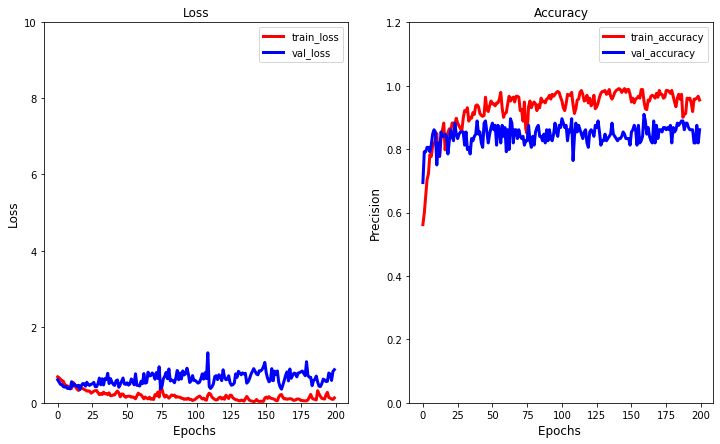

In [18]:
plt.rcParams['figure.figsize'] = [12, 7]

fig, axs = plt.subplots(nrows=1, ncols=2)
axs[0].plot(history.history['loss'], 'r', linewidth=3.0) 
axs[0].plot(history.history['val_loss'], 'b', linewidth=3.0)
axs[0].legend(['train_loss', 'val_loss'], fontsize=10)
axs[0].set_xlabel('Epochs ', fontsize=12)
axs[0].set_ylabel('Loss', fontsize=12)
axs[0].set_ylim(0,10)
axs[0].set_title('Loss', fontsize=12)

axs[1].plot(history.history['accuracy'], 'r', linewidth=3.0) 
axs[1].plot(history.history['val_accuracy'], 'b', linewidth=3.0)
axs[1].legend(['train_accuracy', 'val_accuracy'], fontsize=10)
axs[1].set_xlabel('Epochs ', fontsize=12)
axs[1].set_ylabel('Precision', fontsize=12) 
axs[1].set_ylim(0,1.2)
axs[1].set_title('Accuracy', fontsize=12)
plt.show()

# Evaluate the model

In [19]:
from metrics import confusion_matrix

### Training samples

In [20]:
TP, FP, TN, FN, conf_matrix = confusion_matrix(model, X_train, y_train)

In [21]:
conf_matrix

array([[189.,   6.],
       [  0., 136.]])

In [22]:
print("Accuracy training: %.2f" % ((TP+TN)/(TP+FP+FN+TN)*100) + "%")
print("Recall training: %.2f" % (TP/(TP+FN)*100) + "%")
print("Precicion training: %.2f" % (TP/(TP+FP)*100) + "%")

Accuracy training: 98.19%
Recall training: 100.00%
Precicion training: 96.92%


### Validation samples

In [23]:
TP, FP, TN, FN, conf_matrix = confusion_matrix(model, X_test, y_test)

In [24]:
conf_matrix

array([[62.,  4.],
       [16., 62.]])

In [25]:
print("Accuracy testing: %.2f" % ((TP+TN)/(TP+FP+FN+TN)*100) + "%")
print("Recall testing: %.2f" % (TP/(TP+FN)*100) + "%")
print("Precicion testing: %.2f" % (TP/(TP+FP)*100) + "%")

Accuracy testing: 86.11%
Recall testing: 79.49%
Precicion testing: 93.94%


# Shap analysis - Final version

In [26]:
import pandas as pd
import shap
# load JS visualization code to notebook
shap.initjs()

In [27]:
# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn and spark models)
explainer = shap.DeepExplainer(model, X_train)
shap_values = explainer.shap_values(X_test)

keras is no longer supported, please use tf.keras instead.


In [28]:
X_plot_df = pd.DataFrame(data=X_test[0])
# X_plot_df.columns = ['Timestamp', 'Capacity', 'OC', 'Ec_20_20', 'Ec_60_20', 'W_1_1',
#                      'W_20_20', 'Num_conflicts', 'Climb', 'Cruis', 'Desc']

X_plot_df.columns = ['Divergence', 
                     'Geopotential',
                     'Potential_vorticity',
                     'Relative_humidity',
                     'Specific_cloud_ice_water_content',
                     'Specific_cloud_liquid_water_content',
                     'Specific_humidity', 
                     'Specific_rain_water_content', 
                     'Specific_snow_water_content',
                     'Temperature',
                     'u_component_of_wind',
                     'v_component_of_wind',
                     'vertical_velocity',
                     'vorticity',
                     'Timestamp', 
                     'Capacity', 
                     'OC', 
                     'Ec_20_20', 
                     'Ec_60_20', 
                     'W_1_1',
                     'W_20_20', 
                     'Num_conflicts',
                     'Climb', 
                     'Cruis', 
                     'Desc']

shape_values_plot = shap_values[0][0]

In [29]:
# Collecting a grouping all the other information
for i in range(1, X_test.shape[0]):
    
    X_test_df_add = pd.DataFrame(data=X_test[i])
    X_test_df_add.columns = ['Divergence', 
                             'Geopotential',
                             'Potential_vorticity',
                             'Relative_humidity',
                             'Specific_cloud_ice_water_content',
                             'Specific_cloud_liquid_water_content',
                             'Specific_humidity', 
                             'Specific_rain_water_content', 
                             'Specific_snow_water_content',
                             'Temperature',
                             'u_component_of_wind',
                             'v_component_of_wind',
                             'vertical_velocity',
                             'vorticity',
                             'Timestamp', 
                             'Capacity', 
                             'OC', 
                             'Ec_20_20', 
                             'Ec_60_20', 
                             'W_1_1',
                             'W_20_20', 
                             'Num_conflicts',
                             'Climb', 
                             'Cruis', 
                             'Desc']
    
    X_plot_df = X_plot_df.append(X_test_df_add, ignore_index=True)
    
    shape_values_plot = np.append(shape_values_plot, 
                                  shap_values[0][i], 
                                  axis=0)

#     print(i)

In [30]:
X_plot_df.shape, shape_values_plot.shape

((4320, 25), (4320, 25))

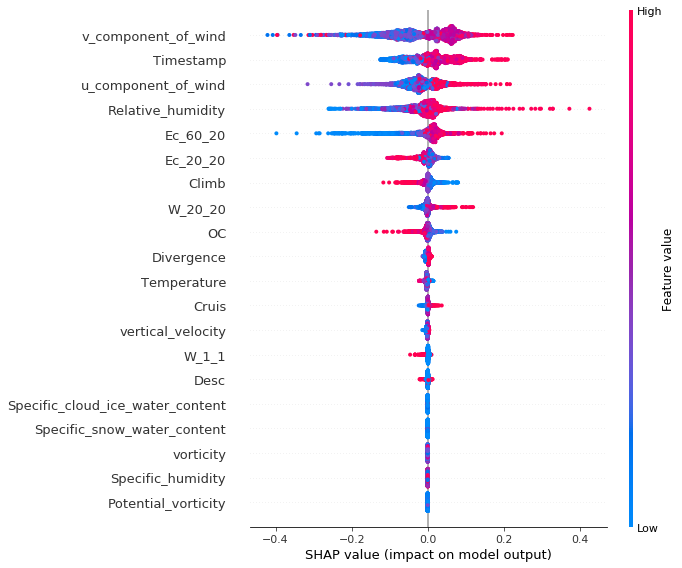

In [31]:
shap.summary_plot(shape_values_plot*10, X_plot_df)

In [32]:
sys.exit()

SystemExit: 

To exit: use 'exit', 'quit', or Ctrl-D.


In [ ]:
shap.force_plot(explainer.expected_value, shape_values_plot, X_plot_df)

In [ ]:
# create a dependence plot to show the effect of a single feature across the whole dataset
shap.dependence_plot("Ec_60_20", shape_values_plot, X_plot_df)

In [ ]:
shap.summary_plot(shape_values_plot*100, X_plot_df, plot_type="bar")